In [1]:
!pip install -U yellowbrick

In [2]:
import numpy as np
import pandas as pd
import datetime
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt, numpy as np
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import AgglomerativeClustering
from matplotlib.colors import ListedColormap
from sklearn import metrics
import warnings
import sys
if not sys.warnoptions:
    warnings.simplefilter("ignore")
np.random.seed(42)

In [3]:
data = pd.read_csv("./marketing_campaign.csv", sep="\t")
print("Número de instâncias:", len(data))
data.head()

Número de instâncias: 2240


,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

In [5]:
# Removendo instâncias com valores nulos
data = data.dropna()
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2216 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2216 non-null   int64  
 1   Year_Birth           2216 non-null   int64  
 2   Education            2216 non-null   object 
 3   Marital_Status       2216 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2216 non-null   int64  
 6   Teenhome             2216 non-null   int64  
 7   Dt_Customer          2216 non-null   object 
 8   Recency              2216 non-null   int64  
 9   MntWines             2216 non-null   int64  
 10  MntFruits            2216 non-null   int64  
 11  MntMeatProducts      2216 non-null   int64  
 12  MntFishProducts      2216 non-null   int64  
 13  MntSweetProducts     2216 non-null   int64  
 14  MntGoldProds         2216 non-null   int64  
 15  NumDealsPurchases    2216 non-null   i

In [6]:
# Convertendo os valores do atributo Dt_Customer para o tipo datetime
data["Dt_Customer"] = pd.to_datetime(data["Dt_Customer"])
dates = []
for i in data["Dt_Customer"]:
    i = i.date()
    dates.append(i)


In [7]:
# Criando atributo "Customer_For", que descreve a quanto tempo uma pessoa é cliente
days = []
d1 = max(dates)
for i in dates:
    delta = d1 - i
    days.append(delta)
data["Customer_For"] = days
data["Customer_For"] = pd.to_numeric(data["Customer_For"], errors="coerce")

In [8]:
# Criando novos atributos
# Idade do cliente
data["Age"] = 2022-data["Year_Birth"]

# Valor total gasto
data["Spent"] = data["MntWines"]+ data["MntFruits"]+ data["MntMeatProducts"]+ data["MntFishProducts"]+ data["MntSweetProducts"]+ data["MntGoldProds"]

# Simplificando estado conjugal para apenas dois valores "partner" ou "alone"
data["Living_With"]=data["Marital_Status"].replace({"Married":"Partner", "Together":"Partner", "Absurd":"Alone", "Widow":"Alone", "YOLO":"Alone", "Divorced":"Alone", "Single":"Alone",})

# Número de crianças vivendo na casa
data["Children"]=data["Kidhome"]+data["Teenhome"]

# Número de pessoas vivendo na casa
data["Family_Size"] = data["Living_With"].replace({"Alone": 1, "Partner":2})+ data["Children"]

# Se o cliente possui filhos ou não
data["Is_Parent"] = np.where(data.Children> 0, 1, 0)

# Simplificando o nível de educação para três valores "Undergraduate", "Graduate" e "Postgraduate"
data["Education"]=data["Education"].replace({"Basic":"Undergraduate","2n Cycle":"Undergraduate", "Graduation":"Graduate", "Master":"Postgraduate", "PhD":"Postgraduate"})

# Simplificando nomes
data=data.rename(columns={"MntWines": "Wines","MntFruits":"Fruits","MntMeatProducts":"Meat","MntFishProducts":"Fish","MntSweetProducts":"Sweets","MntGoldProds":"Gold"})

# Removendo atributos redundantes
to_drop = ["Marital_Status", "Dt_Customer", "Z_CostContact", "Z_Revenue", "Year_Birth", "ID"]
data = data.drop(to_drop, axis=1)

In [9]:
data.describe()

,Income,Kidhome,Teenhome,Recency,Wines,Fruits,Meat,Fish,Sweets,Gold,...,AcceptedCmp1,AcceptedCmp2,Complain,Response,Customer_For,Age,Spent,Children,Family_Size,Is_Parent
count,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,...,2216.000000,2216.000000,2216.000000,2216.000000,2.216000e+03,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000
mean,52247.251354,0.441787,0.505415,49.012635,305.091606,26.356047,166.995939,37.637635,27.028881,43.965253,...,0.064079,0.013538,0.009477,0.150271,4.423735e+16,53.179603,607.075361,0.947202,2.592509,0.714350
std,25173.076661,0.536896,0.544181,28.948352,337.327920,39.793917,224.283273,54.752082,41.072046,51.815414,...,0.244950,0.115588,0.096907,0.357417,2.008532e+16,11.985554,602.900476,0.749062,0.905722,0.451825
min,1730.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000e+00,26.000000,5.000000,0.000000,1.000000,0.000000
25%,35303.000000,0.000000,0.000000,24.000000,24.000000,2.000000,16.000000,3.000000,1.000000,9.000000,...,0.000000,0.000000,0.000000,0.000000,2.937600e+16,45.000000,69.000000,0.000000,2.000000,0.000000
50%,51381.500000,0.000000,0.000000,49.000000,174.500000,8.000000,68.000000,12.000000,8.000000,24.500000,...,0.000000,0.000000,0.000000,0.000000,4.432320e+16,52.000000,396.500000,1.000000,3.000000,1.000000
75%,68522.000000,1.000000,1.000000,74.000000,505.000000,33.000000,232.250000,50.000000,33.000000,56.000000,...,0.000000,0.000000,0.000000,0.000000,5.927040e+16,63.000000,1048.000000,1.000000,3.000000,1.000000
max,666666.000000,2.000000,2.000000,99.000000,1493.000000,199.000000,1725.000000,259.000000,262.000000,321.000000,...,1.000000,1.000000,1.000000,1.000000,9.184320e+16,129.000000,2525.000000,3.000000,5.000000,1.000000


<Figure size 576x396 with 0 Axes>

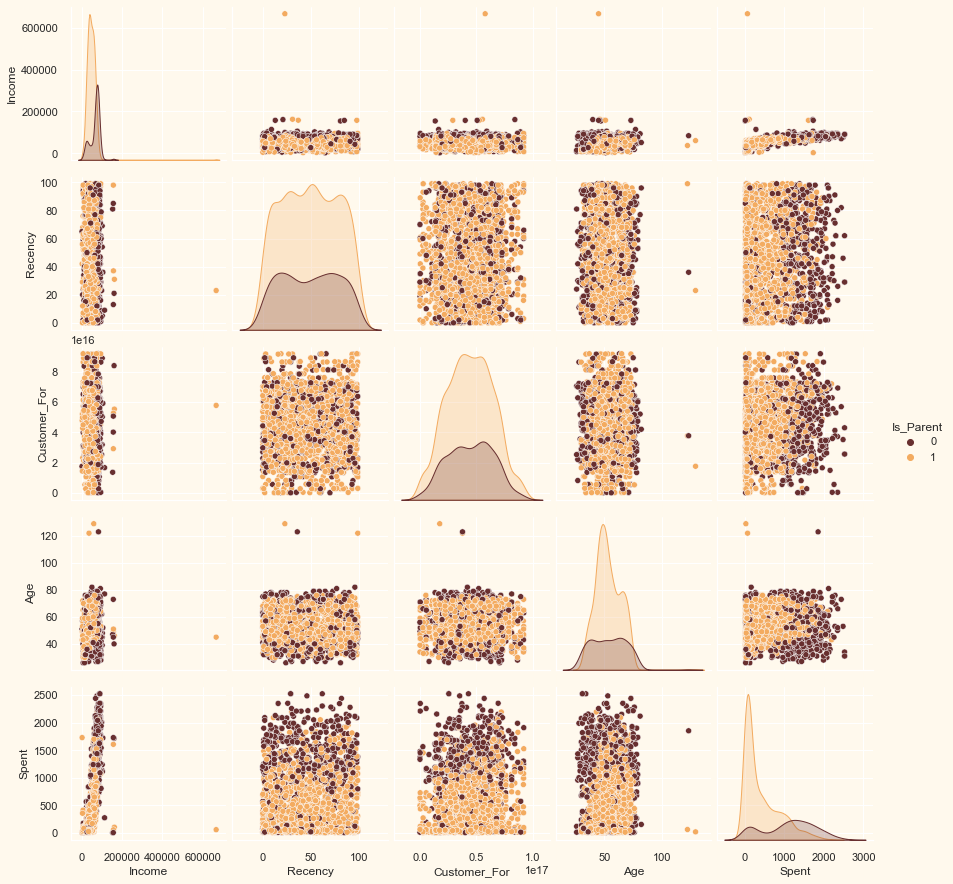

In [10]:
sns.set(rc={"axes.facecolor":"#FFF9ED","figure.facecolor":"#FFF9ED"})
pallet = ["#682F2F", "#9E726F", "#D6B2B1", "#B9C0C9", "#9F8A78", "#F3AB60"]
cmap = colors.ListedColormap(["#682F2F", "#9E726F", "#D6B2B1", "#B9C0C9", "#9F8A78", "#F3AB60"])

# Gerando gráficos para os atributos "Income", "Recency", "Customer_For", "Age", "Spent", "Is_Parent"
To_Plot = [ "Income", "Recency", "Customer_For", "Age", "Spent", "Is_Parent"]
plt.figure()
sns.pairplot(data[To_Plot], hue= "Is_Parent",palette= (["#682F2F","#F3AB60"]))

plt.show()

In [11]:
# Removendo outliers observados nos gráficos acima dos atributos "Age" e "Income"
data = data[(data["Age"]<90)]
data = data[(data["Income"]<600000)]
print("The total number of data-points after removing the outliers are:", len(data))

The total number of data-points after removing the outliers are: 2212


In [12]:
# Lista de variáveis categoricas
s = (data.dtypes == 'object')
object_cols = list(s[s].index)

print("Variáveis categóricas:", object_cols)

Variáveis categóricas: ['Education', 'Living_With']


In [13]:
# Convertendo variáveis categóricas para valores numéricos
LE=LabelEncoder()
for i in object_cols:
    data[i]=data[[i]].apply(LE.fit_transform)

In [14]:
# Normalizando valores usando standard scaler 
ds = data.copy()

# Removendo atributos com valores booleanos (promoções e ofertas aceitas)
cols_del = ['AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1','AcceptedCmp2', 'Complain', 'Response']
ds = ds.drop(cols_del, axis=1)

# Dimensionamento
scaler = StandardScaler()
scaler.fit(ds)
scaled_ds = pd.DataFrame(scaler.transform(ds),columns= ds.columns)

scaled_ds.head()

,Education,Income,Kidhome,Teenhome,Recency,Wines,Fruits,Meat,Fish,Sweets,...,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Customer_For,Age,Spent,Living_With,Children,Family_Size,Is_Parent
0,-0.893586,0.287105,-0.822754,-0.929699,0.310353,0.977660,1.552041,1.690293,2.453472,1.483713,...,2.503607,-0.555814,0.692181,1.973583,1.018352,1.676245,-1.349603,-1.264598,-1.758359,-1.581139
1,-0.893586,-0.260882,1.040021,0.908097,-0.380813,-0.872618,-0.637461,-0.718230,-0.651004,-0.634019,...,-0.571340,-1.171160,-0.132545,-1.665144,1.274785,-0.963297,-1.349603,1.404572,0.449070,0.632456
2,-0.893586,0.913196,-0.822754,-0.929699,-0.795514,0.357935,0.570540,-0.178542,1.339513,-0.147184,...,-0.229679,1.290224,-0.544908,-0.172664,0.334530,0.280110,0.740959,-1.264598,-0.654644,-1.581139
3,-0.893586,-1.176114,1.040021,-0.929699,-0.795514,-0.872618,-0.561961,-0.655787,-0.504911,-0.585335,...,-0.913000,-0.555814,0.279818,-1.923210,-1.289547,-0.920135,0.740959,0.069987,0.449070,0.632456
4,0.571657,0.294307,1.040021,-0.929699,1.554453,-0.392257,0.419540,-0.218684,0.152508,-0.001133,...,0.111982,0.059532,-0.132545,-0.822130,-1.033114,-0.307562,0.740959,0.069987,0.449070,0.632456


<AxesSubplot:>

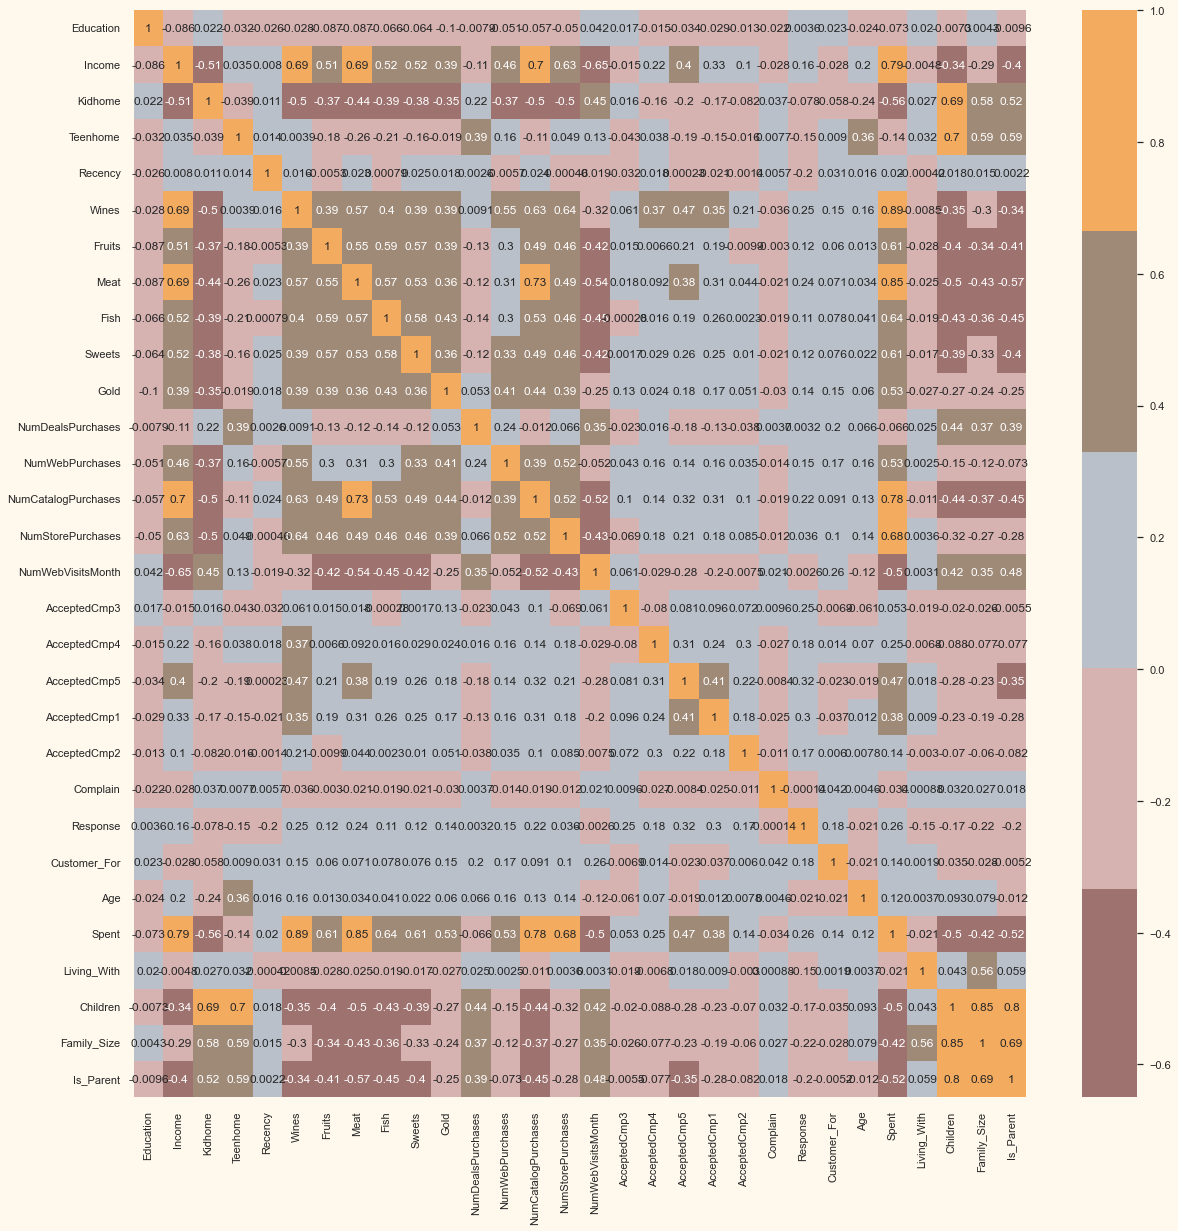

In [15]:
# Gerando Matriz de Correlação
corrmat= data.corr()
plt.figure(figsize=(20,20))  
sns.heatmap(corrmat,annot=True, cmap=cmap, center=0)

In [16]:
# Análise de componentes principais (PCA)

# Vários atributos são correlacionados, e, portanto, redundantes. 
# Para resolver isso, realizamos a redução de dimensionalidade utilizando a técnica de Análise de componentes principais, ou PCA 

# Reduzindo dimensionalidade para apenas 3 componentes
pca = PCA(n_components=3)
pca.fit(scaled_ds)
PCA_ds = pd.DataFrame(pca.transform(scaled_ds), columns=(["col1","col2", "col3"]))
PCA_ds.describe().T

,count,mean,std,min,25%,50%,75%,max
col1,2212.0,1.146360e-16,2.878377,-5.969394,-2.538494,-0.780421,2.383290,7.444305
col2,2212.0,-1.586033e-17,1.706839,-4.312196,-1.328316,-0.158123,1.242289,6.142721
col3,2212.0,3.776866e-17,1.221956,-3.530416,-0.829067,-0.022692,0.799895,6.611222


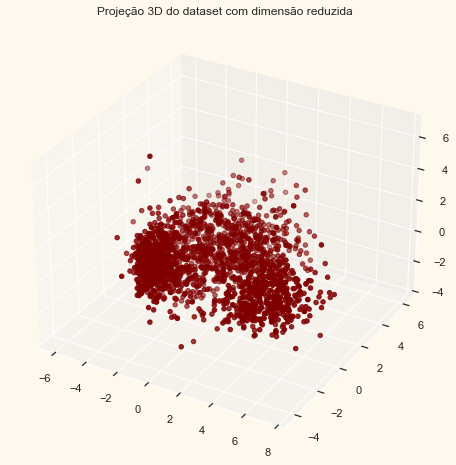

In [17]:
# Projeção 3D do dataset com dimensão reduzida
x =PCA_ds["col1"]
y =PCA_ds["col2"]
z =PCA_ds["col3"]
#To plot
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(x,y,z, c="maroon", marker="o" )
ax.set_title("Projeção 3D do dataset com dimensão reduzida")
plt.show()

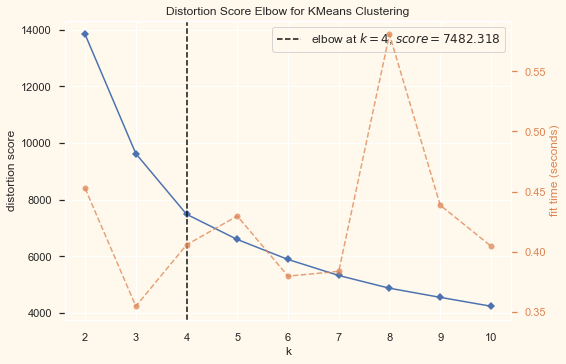

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [18]:
# CLUSTERING

# Utilizando o método do cotovelo para determinar o número de clusters a ser usado
Elbow_M = KElbowVisualizer(KMeans(), k=10)
Elbow_M.fit(PCA_ds)
Elbow_M.show()

In [19]:
# Rodando o algoritmo KMeans com 4 clusters
kmeans = KMeans(n_clusters=4, random_state=0)
# Populando o modelo
y_kmeans = kmeans.fit_predict(PCA_ds)
PCA_ds["Clusters"] = y_kmeans
# Adicionando os clusters ao dataframe
data["Clusters"]= y_kmeans

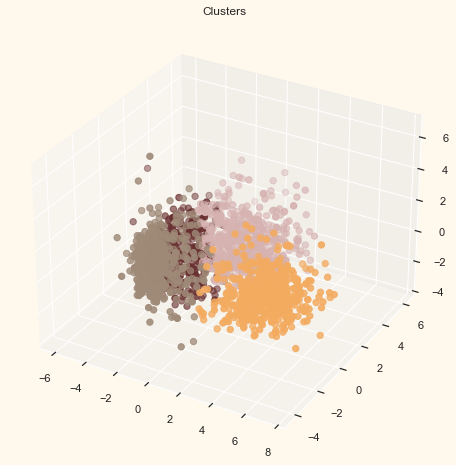

In [20]:
# Mostrando os clusters gerados (cada cor representa um cluster)
fig = plt.figure(figsize=(10,8))
ax = plt.subplot(111, projection='3d', label="bla")
ax.scatter(x, y, z, s=40, c=PCA_ds["Clusters"], marker='o', cmap = cmap )
ax.set_title("Clusters")
plt.show()

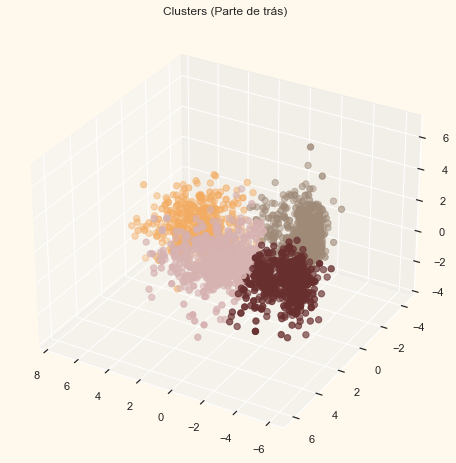

In [21]:
fig = plt.figure(figsize=(10,8))
ax = plt.subplot(111, projection='3d', label="bla")
ax.scatter(x ,y , z, s=40, c=PCA_ds["Clusters"], marker='o', cmap = cmap )
ax.set_title("Clusters (Parte de trás)")
ax.view_init(30, -240)
plt.show()

In [22]:
# Mostrando os clusters em que as 10 primeiras instâncias se encontram
data.head(10)

,Education,Income,Kidhome,Teenhome,Recency,Wines,Fruits,Meat,Fish,Sweets,...,Complain,Response,Customer_For,Age,Spent,Living_With,Children,Family_Size,Is_Parent,Clusters
0,0,58138.0,0,0,58,635,88,546,172,88,...,0,1,83894400000000000,65,1617,0,0,1,0,3
1,0,46344.0,1,1,38,11,1,6,2,1,...,0,0,10800000000000000,68,27,0,2,3,1,0
2,0,71613.0,0,0,26,426,49,127,111,21,...,0,0,40780800000000000,57,776,1,0,2,0,3
3,0,26646.0,1,0,26,11,4,20,10,3,...,0,0,5616000000000000,38,53,1,1,3,1,2
4,1,58293.0,1,0,94,173,43,118,46,27,...,0,0,27734400000000000,41,422,1,1,3,1,0
5,1,62513.0,0,1,16,520,42,98,0,42,...,0,0,39139200000000000,55,716,1,1,3,1,1
6,0,55635.0,0,1,34,235,65,164,50,49,...,0,0,65059200000000000,51,590,0,1,2,1,1
7,1,33454.0,1,0,32,76,10,56,3,1,...,0,0,42163200000000000,37,169,1,1,3,1,2
8,1,30351.0,1,0,19,14,0,24,3,3,...,0,1,47347200000000000,48,46,1,1,3,1,2
9,1,5648.0,1,1,68,28,0,6,1,1,...,0,0,23155200000000000,72,49,1,2,4,1,0
